# Model Training

In [1]:
# Packages 
import pandas as pd 
import numpy as np 
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import MinMaxScaler 
from sklearn.cluster import KMeans 
from sklearn.svm import OneClassSVM
import matplotlib.cm as cm
from matplotlib import pyplot
from sklearn import datasets, linear_model
from sklearn.linear_model import LogisticRegression

import sys
import os

print(os.getcwd())
ROOT_DIR = os.path.dirname(os.path.dirname(os.path.abspath("ds_proj1")))
os.chdir(ROOT_DIR)
print(os.getcwd())

d:\00_DEVELOPER\globant\ds_proj1\notebooks
d:\00_DEVELOPER\globant\ds_proj1


In [2]:
df = pd.read_csv('data/interim/data_standar.csv')

In [3]:
# Creating dataframe with relevant features 
transation_features = ['original_gross_amt', 'trans_tax_amt']
turnover = df[transation_features]
turnover.head()

,original_gross_amt,trans_tax_amt
0,-0.025855,0.167890
1,-0.025935,0.167113
2,-0.036303,0.072129
3,-0.017417,0.245275
4,-0.022495,0.198689


In [4]:
# Normalizing data
scaler = MinMaxScaler().fit(turnover)
scaled_turnover = scaler.transform(turnover)
scaled_turnover

array([[3.56447183e-04, 9.56246402e-03],
       [3.55838300e-04, 9.54519286e-03],
       [2.76934246e-04, 7.43235463e-03],
       ...,
       [5.10387094e-05, 1.38169257e-03],
       [5.10387094e-05, 0.00000000e+00],
       [3.13073234e-04, 0.00000000e+00]])

###  Determing n_clusters (k)

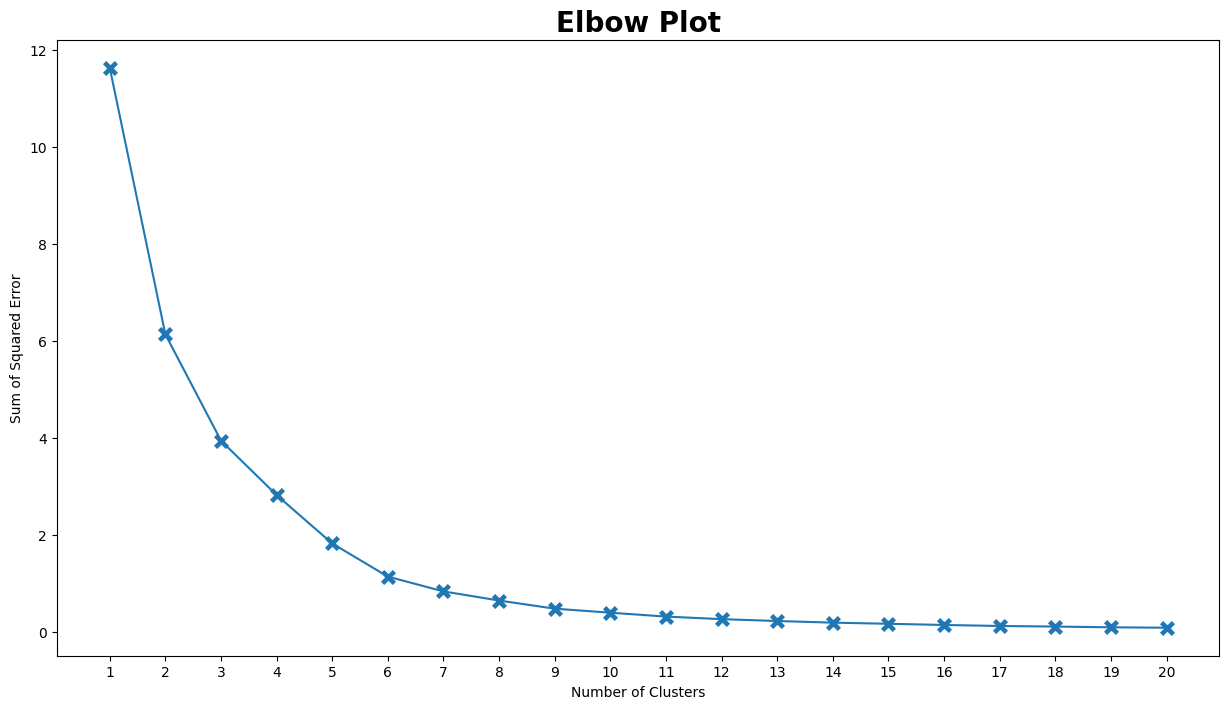

Total error: 0.09

Best candidates for number of clusters: 3, 4 and 5;


In [5]:
# Choosing optimal number of clusters through sum of squared errors plot
sse = []
n_clusters = 20

for k in range(1, n_clusters + 1):
    km = KMeans(n_clusters=k, random_state=0).fit(scaled_turnover)
    sse.append(km.inertia_) 
    
#creating a dataframe for the sum of squared error results
df_sse = pd.DataFrame({'Number of Clusters': range(1, n_clusters + 1), 'Sum of Squared Error': sse})

#plotting sum of squared error results
plt.figure(figsize = (15, 8))
sns.lineplot(df_sse, x = 'Number of Clusters', y = 'Sum of Squared Error')
sns.scatterplot(df_sse, x = 'Number of Clusters', y = 'Sum of Squared Error', marker = 'X', s = 150)

#customizing
plt.xticks(range(1, n_clusters +1, 1))
plt.title('Elbow Plot', fontweight = 'bold', fontsize=20)

plt.show() 

print(f'Total error: {round(km.inertia_,2)}\n\nBest candidates for number of clusters: 3, 4 and 5;')

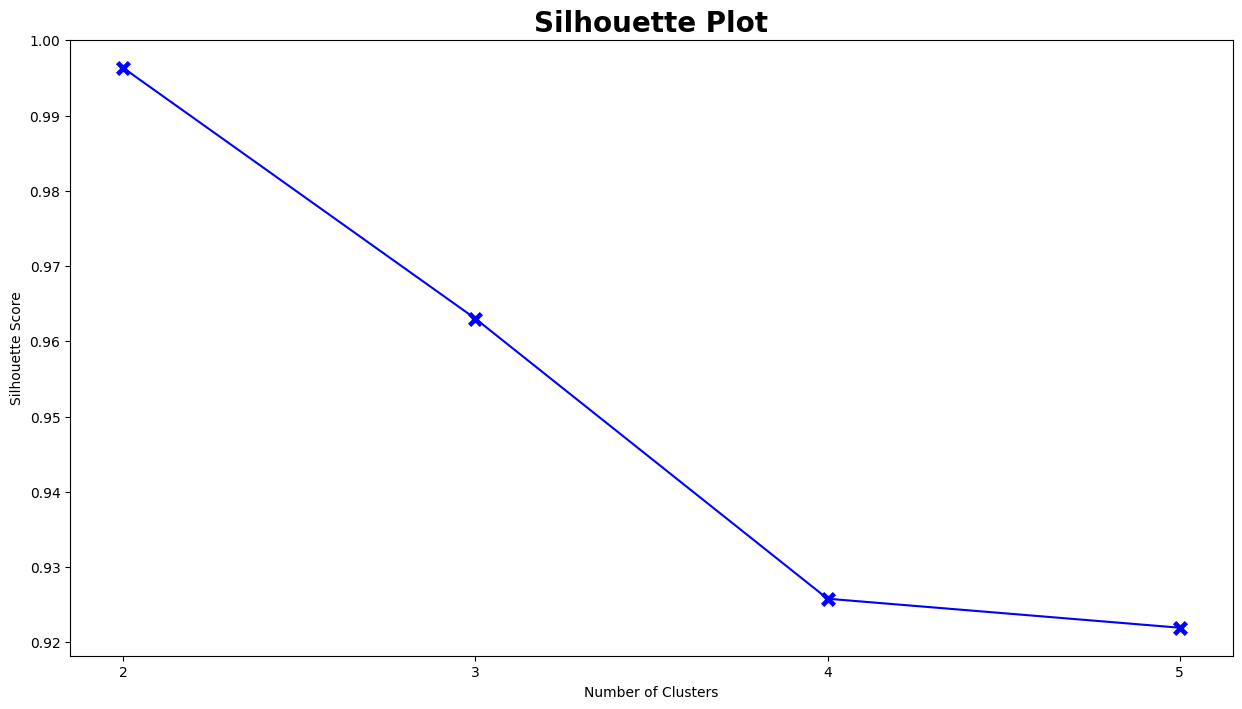

For n_clusters = 2 The average silhouette score is : 1.0
For n_clusters = 3 The average silhouette score is : 0.96
For n_clusters = 4 The average silhouette score is : 0.93
For n_clusters = 5 The average silhouette score is : 0.92


In [6]:
# Benchmarking clusters by measuring the degree of separation between candidates for k through silhouette score 
candidates = [2,3,4,5] 
sc = [] 

for n_clusters in candidates:
    km = KMeans(n_clusters=n_clusters, random_state=0)
    km_labels = km.fit_predict(turnover)
    score = silhouette_score(turnover, km_labels)
    sc.append(score) 
    
#creating a dataframe for the sum of silhouette score
df_sc = pd.DataFrame({'Number of Clusters': range(2, 6), 'Silhouette Score': sc})

#plotting sum of squared error results
plt.figure(figsize = (15, 8))
sns.lineplot(df_sc, x = 'Number of Clusters', y = 'Silhouette Score', color='blue')
sns.scatterplot(df_sc, x = 'Number of Clusters', y = 'Silhouette Score', marker = 'X', s = 150,color='blue')

#customizing
plt.xticks([2,3,4,5])
plt.title('Silhouette Plot', fontweight='bold', fontsize=20)

plt.show()  

# printing silhouette scores
for n_clusters in candidates:  
    km = KMeans(n_clusters=n_clusters, random_state=0)
    km_labels = km.fit_predict(turnover)
    score = silhouette_score(turnover, km_labels)
    print('For n_clusters =', n_clusters,'The average silhouette score is :',round(score,2))

### Clustering

In [7]:
# Adding the cluster labels as a new feature called turnover_segmentation in my clustered dataset
k = 3
km = KMeans(n_clusters=k, random_state=0).fit(scaled_turnover) 
labels = km.labels_
#df_cluster['segmentation'] = labels
km
# Checking turnover segmentation features according to centroids 
#centroids = km[transation_features].mean().round(2)
#centroids

KMeans(n_clusters=3, random_state=0)

In [8]:
# Splitting the ORIGINAL GROSS AMOUNT time series data into training and testing datasets (70%+30%)

train_set = df.iloc[0:int(len(df)*0.7),1]
test_set = df.iloc[int(len(df)*0.7)+1:len(df),1]


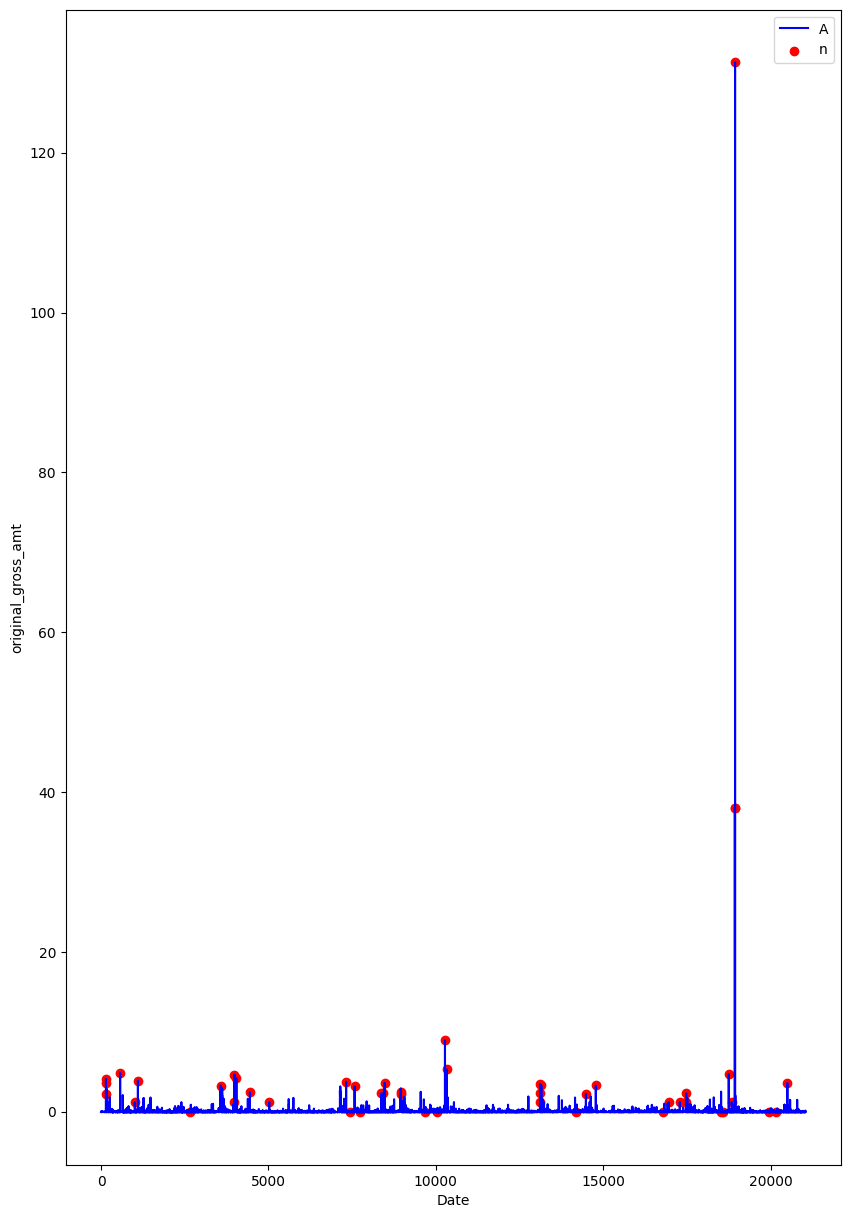

In [10]:
# Training the One-Class SVM model 

ocsvm_model = OneClassSVM(gamma ="auto",nu=0.0025).fit(df['original_gross_amt'].values.reshape(-1,1))
ocsvm_model.predict(df['original_gross_amt'].values.reshape(-1,1))
ocsvm_decision_func = ocsvm_model.decision_function(df['original_gross_amt'].values.reshape(-1,1))
ocsvm_score = ocsvm_model.score_samples(df['original_gross_amt'].values.reshape(-1,1))

df['INT_TIME'] = df.index.astype(np.int64)
df['ocsvm_decis_func'] = ocsvm_decision_func
anomaly = df.loc[df['ocsvm_decis_func']<0, ['INT_TIME','original_gross_amt']]
normal = df.loc[df['ocsvm_decis_func']>=0, ['INT_TIME','original_gross_amt']]

fig, ax = plt.subplots(figsize=(10,15))
ax.plot(df['INT_TIME'],df['original_gross_amt'], color='blue',label='Normal')
ax.scatter(anomaly['INT_TIME'],anomaly['original_gross_amt'], color='red', label='Anomaly')

plt.xlabel('Date')
plt.ylabel('original_gross_amt')
plt.legend('Anomaly detection using OCSVM')
plt.show()

In [12]:
anomaly_fraction = len(anomaly)/len(df['original_gross_amt'])
anomaly_fraction

0.002280501710376283